In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
import os
import mne
from mne.io import concatenate_raws, read_raw_edf
import json
import scipy.io
import pandas as pd
from pandas import read_excel
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


# Extracting eeg data from txt file

In [2]:
file = open("OpenBCI-RAW-2019-07-02_16-12-07.txt","r")
file_1 = file.readlines()
file_new = open("New","a")
j = 0
for i in file_1:
    j = j+1
#     print(i)
    if j >=7:
        file_new.write(i)


# Deduplication and conversion to array

In [3]:
df = pd.read_csv('new',names=['sample_index','e1','e2','e3','e4','accel_x','accel_y','aux','timestamp'])
# print(df)
df.drop_duplicates(subset=['e1','e2','e3','e4','timestamp'], keep='last', inplace=True)
df = df.iloc[:,[1,2,3,4]]
data = df.to_numpy()
data = data.T
print(data)

[[1009.   1070.27 1080.52 ...  782.84  852.3   961.04]
 [1696.89 1697.09 1683.24 ... 1697.47 1695.16 1690.86]
 [1515.57 1513.61 1503.73 ... 1509.83 1511.2  1508.43]
 [-437.75 -433.05 -435.98 ... -385.62 -420.35 -417.64]]


# Mne object 

In [4]:
n_channels = 4
sfreq = 200
ch_names = ['ch1','ch2','ch3','ch4']
info = mne.create_info(n_channels, sfreq, ch_types='eeg', verbose=None)
print(info)
new_data = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)
print(new_data)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 200.0 Hz
>
Creating RawArray with float64 data, n_channels=4, n_times=150871
    Range : 0 ... 150870 =      0.000 ...   754.350 secs
Ready.
<RawArray | 4 x 150871 (754.4 s), ~4.6 MB, data loaded>


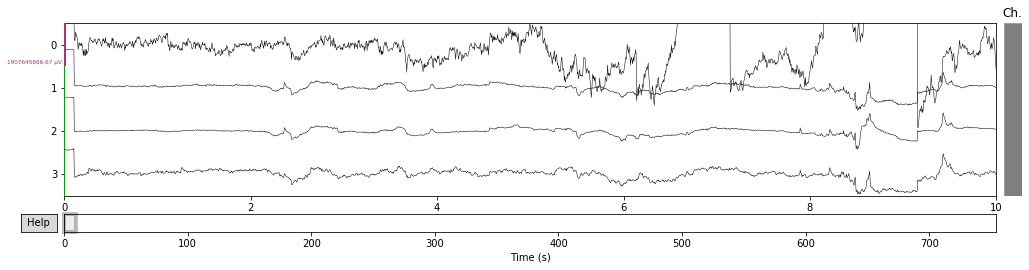

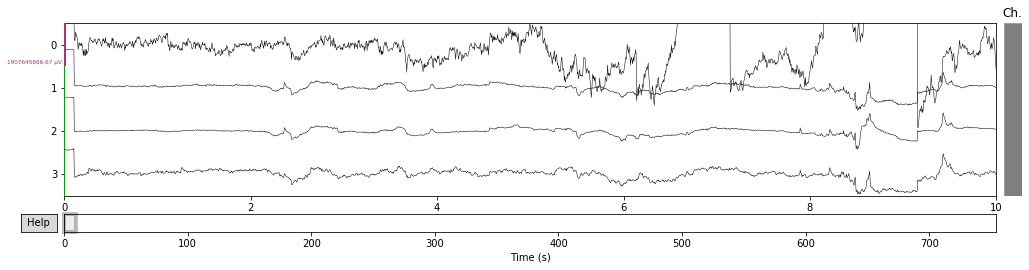

In [5]:
new_data.plot(scalings='auto')

# Rereferencing

In [6]:
# let the references be mastoid for now

# Filtering

## FIR band pass filtering (0.1, 45)Hz

In [7]:
l_freq = 0.1
h_freq = 45
filter_data = new_data.filter(l_freq, h_freq, picks='eeg',filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6601 samples (33.005 sec)



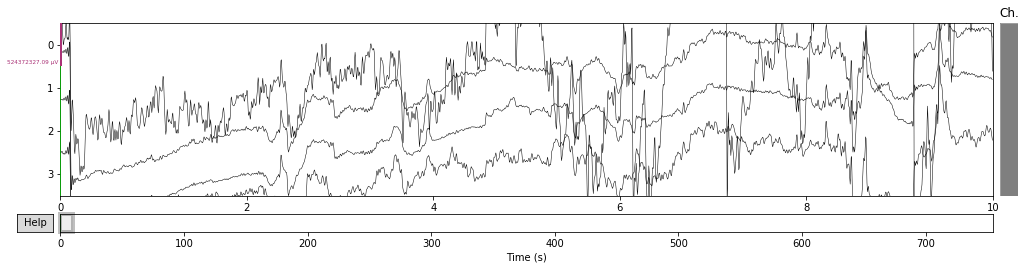

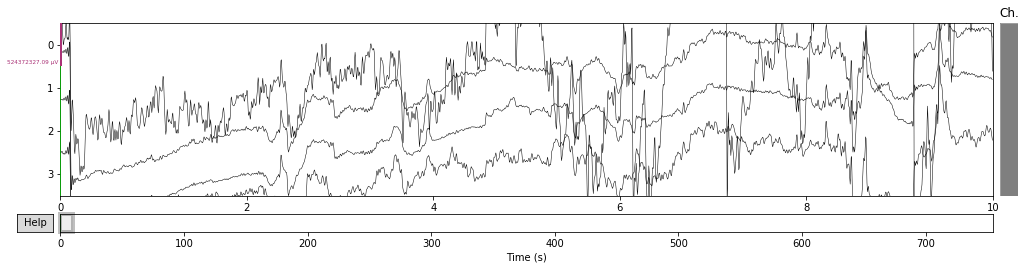

In [8]:
filter_data.plot(scalings='auto')

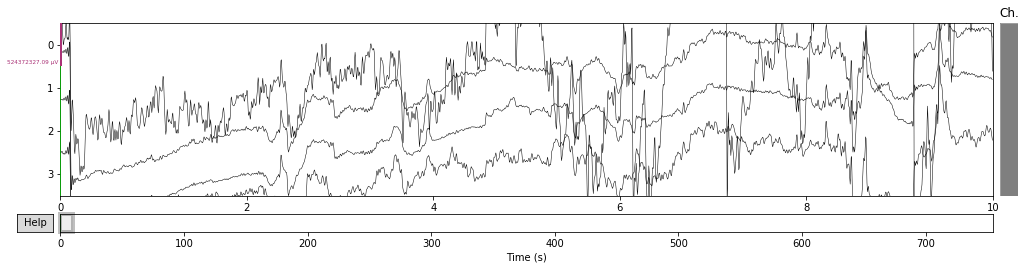

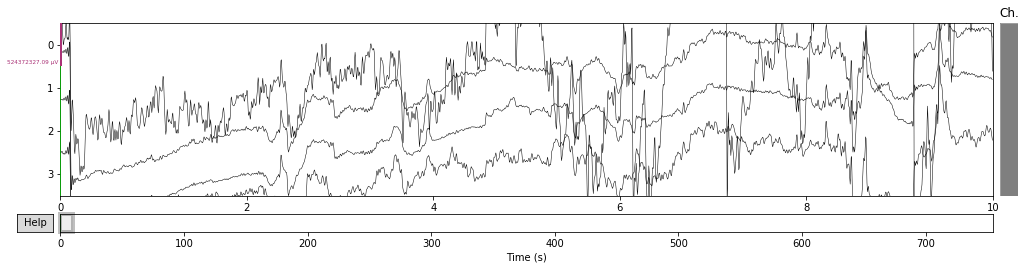

In [9]:
new_data.plot(scalings='auto')

## Notch filter 60 Hz

In [10]:
freqs = 60
notch_data = filter_data.notch_filter(freqs, picks='eeg', filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=1, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1321 samples (6.605 sec)



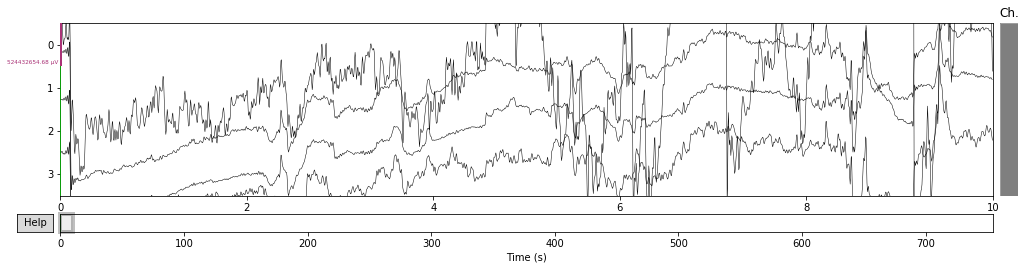

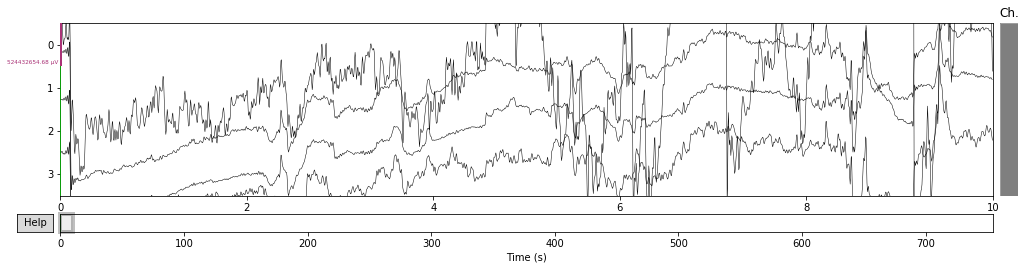

In [11]:
notch_data.plot(scalings='auto')

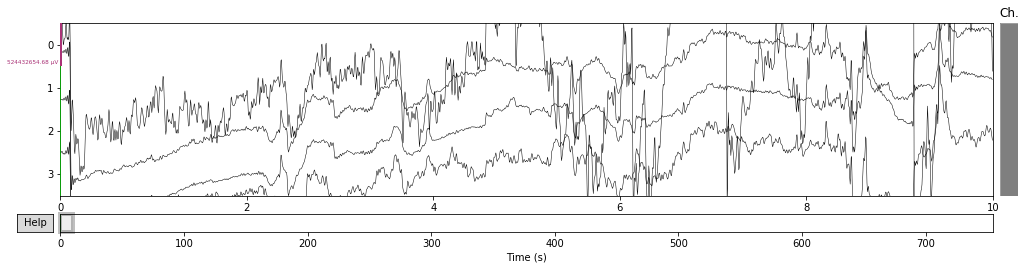

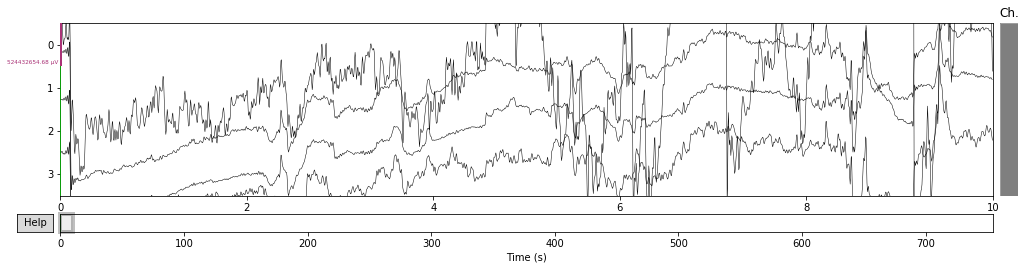

In [12]:
new_data.plot(scalings='auto')

# Fit data to montage

# ICA

In [13]:
from mne.preprocessing import ICA
ica = ICA(n_components = 4, random_state=97)
ica.fit(notch_data, picks='eeg')

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 4 components
Fitting ICA took 0.2s.


<ICA  |  raw data decomposition, fit (fastica): 150871 samples, 4 components, channels used: "eeg">

## ICA Components

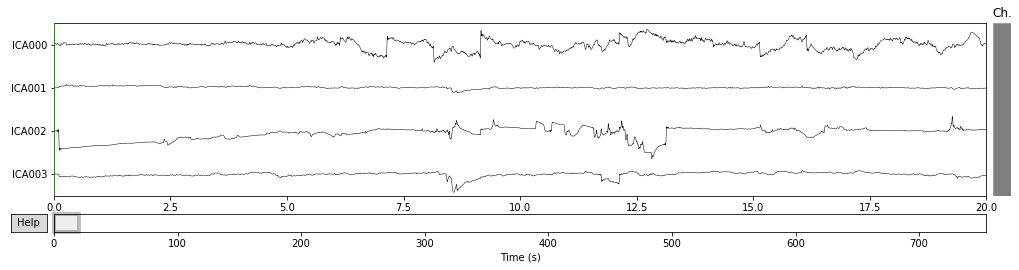

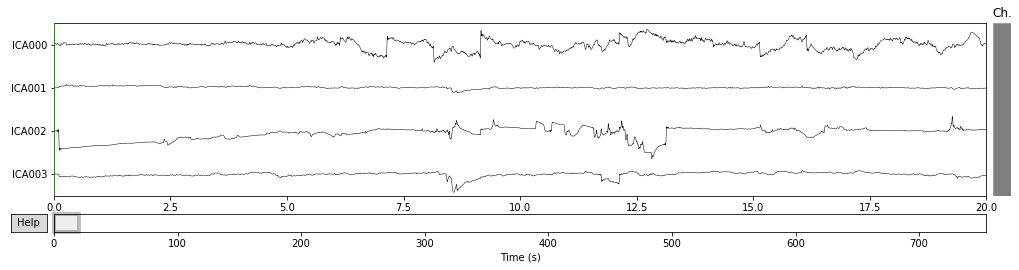

In [14]:
new_data.load_data()
ica.plot_sources(notch_data)

Transforming to ICA space (4 components)
Zeroing out 0 ICA components


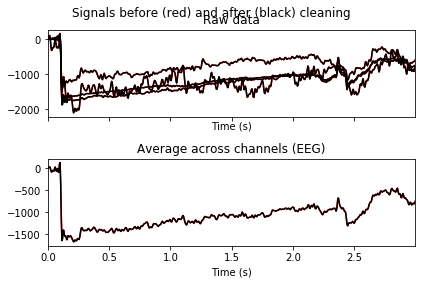

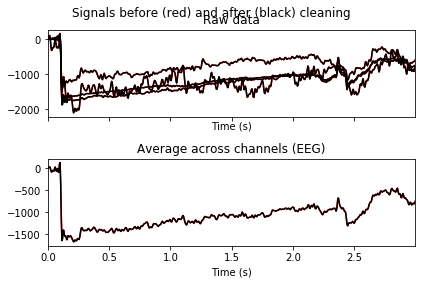

In [15]:
ica.plot_overlay(notch_data)

## Exclude components

In [16]:
ica.exclude = [0]

## Reconstruction

In [17]:
reconst_raw = notch_data.copy()
ica.apply(reconst_raw)

Transforming to ICA space (4 components)
Zeroing out 1 ICA component


<RawArray | 4 x 150871 (754.4 s), ~4.6 MB, data loaded>

## Comparison

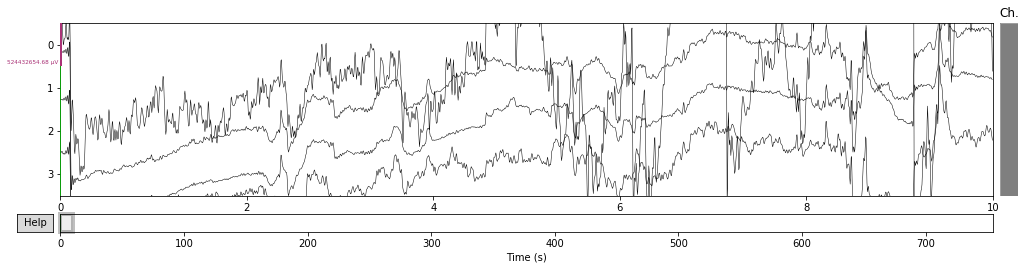

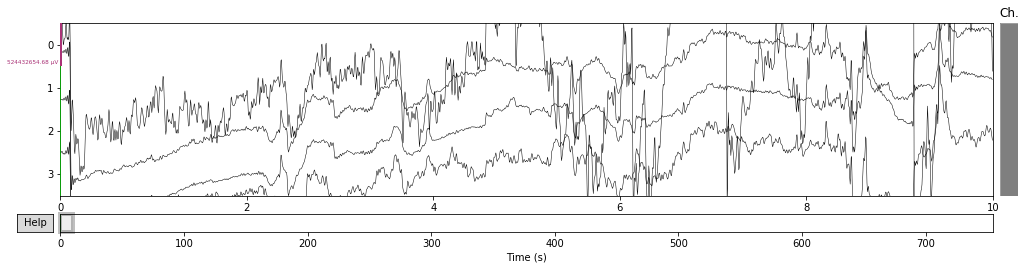

In [18]:
notch_data.plot(scalings='auto')

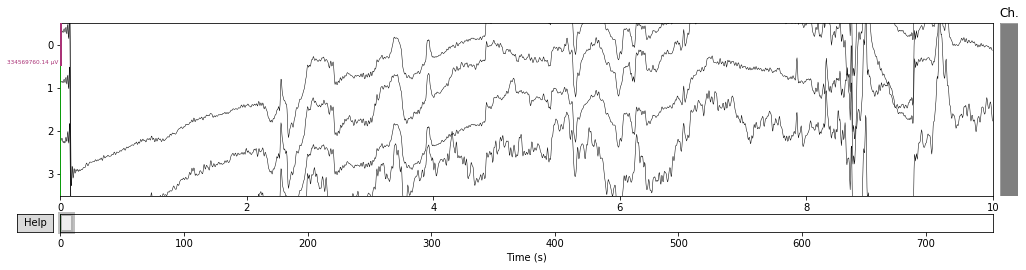

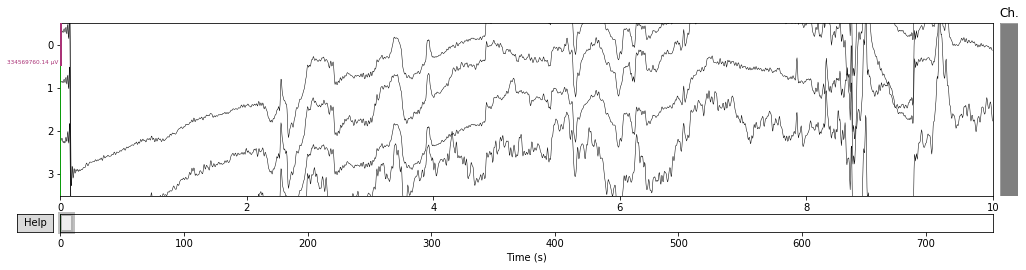

In [19]:
reconst_raw.plot(scalings='auto')

# Filtering again

In [20]:
l_freq = 0.1
h_freq = 45
preprocess_data = reconst_raw.filter(l_freq, h_freq, picks='eeg',filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6601 samples (33.005 sec)



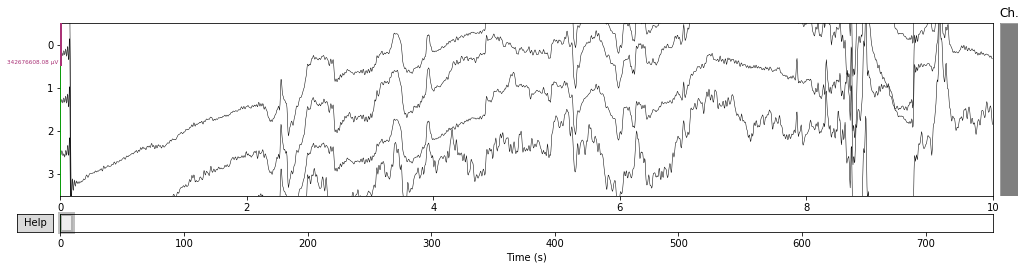

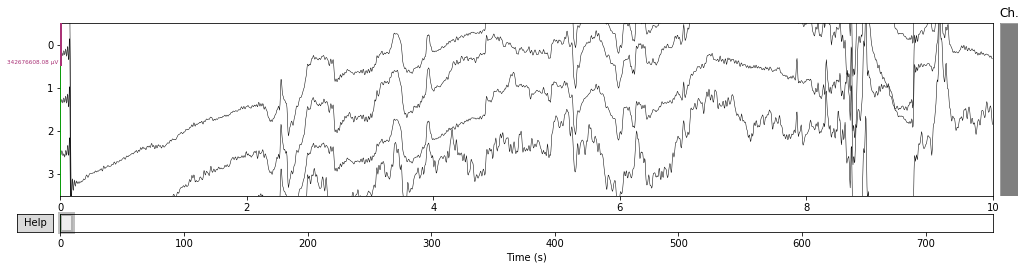

In [21]:
preprocess_data.plot(scalings='auto')

# Markers data

In [22]:
event_markers = pd.read_excel('07011905_2019.07.02_16.19.58_bci.xlsx')
event_ids = [1,2,3,4,5]
event_keys = {"EyesOpenedStart":1, "EyesOpenedEnd":2, "EyesClosedStart":3, "EyesClosedEnd":4, 
              "PenaltyKickTrial":5}
onset = event_markers["time"]
index = event_markers["marker"]

# Epoching data

In [23]:
events = np.array(event_markers[["latency","marker","marker"]])
epochs = mne.Epochs(preprocess_data, events, event_id = event_ids, tmin = - 0.5, tmax = 3, baseline=None, picks=None, 
                    preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, 
                    reject_tmax=None, detrend=None, on_missing='warning', reject_by_annotation=True, 
                    metadata=None, event_repeated='error', verbose=None)

55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


Loading data for 55 events and 701 original time points ...
0 bad epochs dropped
Loading data for 55 events and 701 original time points ...
Loading data for 20 events and 701 original time points ...


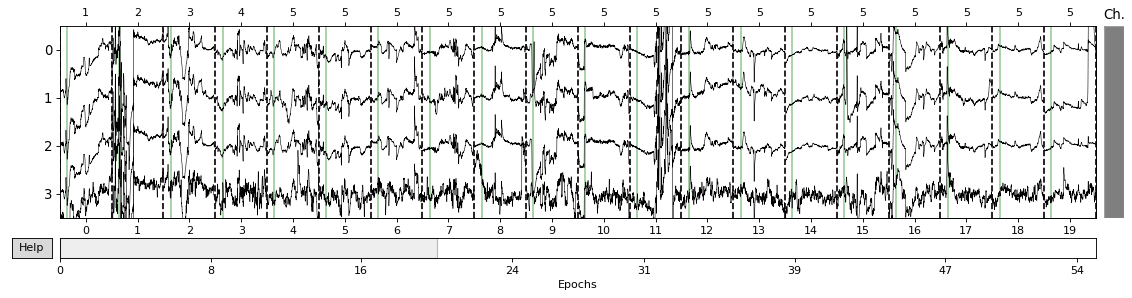

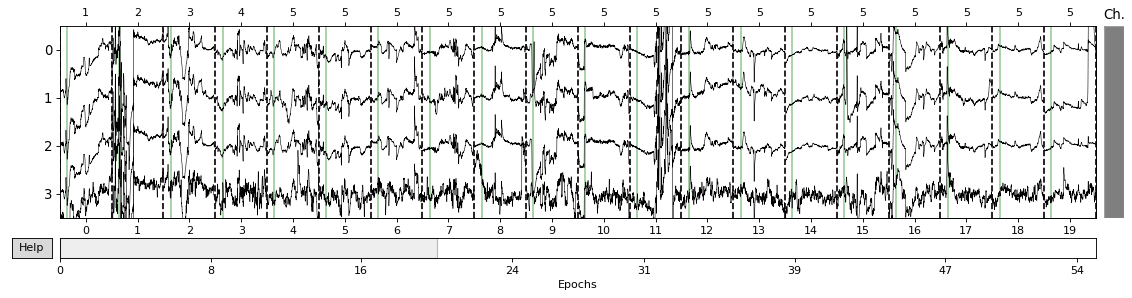

In [24]:
epochs.plot(event_id=event_ids, scalings='auto')

# Band power analysis

In [25]:
EyesOpenedStart = epochs[0]
EyesOpenedEnd = epochs[1]
EyesClosedStart = epochs[2]
EyesClosedEnd = epochs[3]
from mne.time_frequency import psd_multitaper
n_fft = 2048

## Multi-taper technique

In [26]:
def bandpower(data, sf, low, high, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    # Compute the modified periodogram (Welch)
    psd_total, freqs_total = psd_multitaper(data, low_bias=True, proj=True, n_jobs=1)
    psd, freqs = psd_multitaper(data, fmin=low, fmax=high, low_bias=True, proj=True, n_jobs=1)

    # Frequency resolution
    freq_res = freqs_total[1] - freqs_total[0]

    # Find index of band in frequency vector
    # idx_band = np.logical_and(psd[:,] >= low, psd[:,] <= high)
    
    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd, dx=freq_res)

    if relative:
        bp = simps(psd, dx=freq_res) / simps(psd_total, dx=freq_res)
    return bp

In [27]:
sf = 200
delta_low = 0.5
delta_high = 4

theta_low = 4
theta_high = 8

alpha_low = 8
alpha_high = 12

beta_low = 12
beta_high = 30

In [28]:
bp_0_delta = bandpower(epochs[0], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
bp_0_theta = bandpower(epochs[0], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
bp_0_alpha = bandpower(epochs[0], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
bp_0_beta = bandpower(epochs[0], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

bp_2_delta = bandpower(epochs[2], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
bp_2_theta = bandpower(epochs[2], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
bp_2_alpha = bandpower(epochs[2], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
bp_2_beta = bandpower(epochs[2], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 701 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 701 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 701 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 701 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 701 original time points ...
    Using multitaper spectrum estimation with 

### Relative band power average over channels

In [29]:
print("Eyes Opened Start")
print("delta",np.average(bp_0_delta)*100,"%")
print("theta",np.average(bp_0_theta)*100,"%")
print("alpha",np.average(bp_0_alpha)*100,"%")
print("beta",np.average(bp_0_beta)*100,"%\n")

print("Eyes Closed Start")
print("delta",np.average(bp_2_delta)*100,"%")
print("theta",np.average(bp_2_theta)*100,"%")
print("alpha",np.average(bp_2_alpha)*100,"%")
print("beta",np.average(bp_2_beta)*100,"%\n")

Eyes Opened Start
delta 50.851472751299845 %
theta 1.7901773155372696 %
alpha 0.41830874481836694 %
beta 0.6581012761871488 %

Eyes Closed Start
delta 64.99226397747337 %
theta 2.4070758185885657 %
alpha 1.2082000227872425 %
beta 2.0081490942853795 %



In [30]:
print("Delta")
print("Eyes Opened Start",np.average(bp_0_delta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_delta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_delta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_delta)*100,"%\n")

print("Theta")
print("Eyes Opened Start",np.average(bp_0_theta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_theta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_theta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_theta)*100,"%\n")

print("Alpha")
print("Eyes Opened Start",np.average(bp_0_alpha)*100,"%")
# print("Eyes Opened End",np.average(bp_1_alpha)*100,"%")
print("Eyes Closed Start",np.average(bp_2_alpha)*100,"%")
# print("Eyes Closed End",np.average(bp_3_alpha)*100,"%\n")

print("Beta")
print("Eyes Opened Start",np.average(bp_0_beta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_beta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_beta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_beta)*100,"%\n")

Delta
Eyes Opened Start 50.851472751299845 %
Eyes Closed Start 64.99226397747337 %
Theta
Eyes Opened Start 1.7901773155372696 %
Eyes Closed Start 2.4070758185885657 %
Alpha
Eyes Opened Start 0.41830874481836694 %
Eyes Closed Start 1.2082000227872425 %
Beta
Eyes Opened Start 0.6581012761871488 %
Eyes Closed Start 2.0081490942853795 %


# Behavioural data

In [31]:
beh_data  = pd.read_excel('outcome_data.xlsx', header=None)
# print(beh_data)
beh_data = np.array(beh_data)
outcome = beh_data[:,3] 
# print(outcome)
emo = np.array(beh_data[:,4])
foc = np.array(beh_data[:,5])
emo_new = np.zeros(50)
foc_new = np.zeros(50)

In [32]:
# 4 class labeling 
for i in range(0,50):
    if emo[i]<25:
        emo_new[i]=0
    else:
        if emo[i]<50:
            emo_new[i]=1
        else:
            if emo[i]<75:
                emo_new[i]=2
            else:
                if emo[i]<101:
                    emo_new[i]=3
print(emo_new)

for i in range(0,50):
    if foc[i]<25:
        foc_new[i]=0
    else:
        if foc[i]<50:
            foc_new[i]=1
        else:
            if foc[i]<75:
                foc_new[i]=2
            else:
                if foc[i]<101:
                    foc_new[i]=3
print(foc_new)

[2. 3. 2. 2. 2. 3. 3. 3. 2. 3. 2. 3. 1. 2. 3. 0. 2. 2. 3. 3. 2. 0. 1. 2.
 1. 3. 2. 3. 3. 1. 3. 1. 2. 2. 2. 2. 1. 0. 1. 1. 2. 3. 2. 1. 2. 2. 2. 1.
 2. 2.]
[3. 3. 3. 0. 2. 3. 3. 3. 2. 2. 2. 3. 2. 1. 2. 2. 2. 3. 2. 2. 3. 2. 3. 3.
 2. 2. 2. 3. 3. 2. 2. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 2.
 1. 1.]


# Predicting outcome data

# Linear Discriminant Analysis

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Epochs to Array

In [34]:
#selecting all the channels and converting to dataframe
df = epochs[4:54].to_data_frame()
#converting dataframe to numpy array
X = df.to_numpy()
#intialising outcome for that event by random number 1, 2 for now
y = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y[idx] = outcome[i-4]

Loading data for 50 events and 701 original time points ...


In [35]:
# evaluate a lda model on the dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# All channels LDA

In [36]:
X_ch = X[:,3:7]
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.539 (0.003)


# Single channel LDA

In [37]:
def single_channel_LDA(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearDiscriminantAnalysis()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

## Mean prediction accuracy

In [38]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.537 (0.001)
Mean Accuracy: 0.538 (0.001)
Mean Accuracy: 0.536 (0.001)
Mean Accuracy: 0.539 (0.001)


# Logistic regression 

In [40]:
from sklearn.linear_model import LogisticRegression
# define model
model = LogisticRegression()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.492 (0.009)


# Single channel

In [41]:
def single_channel_reg(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LogisticRegression()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [42]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_reg(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.455 (0.005)
Mean Accuracy: 0.477 (0.006)
Mean Accuracy: 0.461 (0.006)
Mean Accuracy: 0.490 (0.008)


# SVM

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics
# define model
model = LinearSVC(dual = False)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.492 (0.009)


# Single channel

In [44]:
def single_channel_svc(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearSVC(dual = False)
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [45]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_svc(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.455 (0.005)
Mean Accuracy: 0.477 (0.006)
Mean Accuracy: 0.461 (0.006)
Mean Accuracy: 0.490 (0.008)


# Predicting emo/foc data

## y_emo, y_foc

In [46]:
y_emo = np.zeros(len(X))
y_foc = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_emo[idx] = emo_new[i-4]
    y_foc[idx] = foc_new[i-4]

## plot behavioural data

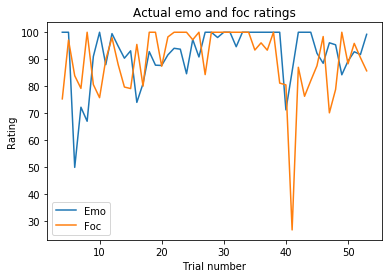

In [41]:
epoch_idx = np.arange(4,54,1)
plt.title("Actual emo and foc ratings")
plt.xlabel("Trial number")
plt.ylabel("Rating")
plt.plot(epoch_idx, emo, label="Emo")
plt.plot(epoch_idx, foc, label="Foc")
plt.legend()
plt.savefig("Behavioural ratings")

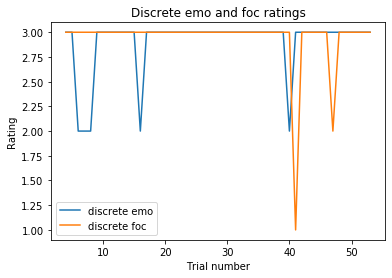

In [42]:
plt.title("Discrete emo and foc ratings")
plt.xlabel("Trial number")
plt.ylabel("Rating")
plt.plot(epoch_idx, emo_new, label="discrete emo")
plt.plot(epoch_idx, foc_new, label="discrete foc")
plt.legend()
plt.savefig("Discretised behavioural ratings")

## without outcome information

# multiclass

In [47]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler

## Emo ratings classification

### one vs rest (ovr)

In [44]:
clf_ovr_emo = make_pipeline(StandardScaler(), 
                    OneVsRestClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovr_emo
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))                                                                                     

KeyboardInterrupt: 

### one vs one (ovo)

In [ ]:
clf_ovo_emo = make_pipeline(StandardScaler(), 
                    OneVsOneClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovo_emo
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

### output code classifier (occ)

In [ ]:
clf_occ_emo = make_pipeline(StandardScaler(), 
                    OutputCodeClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_occ_emo
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# foc ratings

In [ ]:
clf_ovr_foc = make_pipeline(StandardScaler(), 
                    OneVsRestClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovr_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))                                                                                     

In [ ]:
clf_ovo_foc = make_pipeline(StandardScaler(), 
                    OneVsOneClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovo_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

In [ ]:
clf_occ_foc = make_pipeline(StandardScaler(), 
                    OutputCodeClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_occ_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# LDA

## all channel LDA emo and foc

In [51]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.459 (0.002)


In [52]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.560 (0.000)


## Single channel LDA

In [48]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_emo, i)
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_foc, i)

Channels and Mean accuracies
Mean Accuracy: 0.459 (0.001)
Mean Accuracy: 0.460 (0.000)
Mean Accuracy: 0.459 (0.001)
Mean Accuracy: 0.459 (0.001)
Channels and Mean accuracies
Mean Accuracy: 0.560 (0.000)
Mean Accuracy: 0.560 (0.000)
Mean Accuracy: 0.560 (0.000)
Mean Accuracy: 0.560 (0.000)


# Foc ratings classification

## one vs rest (ovr)

In [ ]:
clf_ovr_foc = make_pipeline(StandardScaler(), 
                    OneVsRestClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovr_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))                                                                                     

In [ ]:
clf_ovo_foc = make_pipeline(StandardScaler(), 
                    OneVsOneClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovo_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

In [ ]:
clf_occ_foc = make_pipeline(StandardScaler(), 
                    OutputCodeClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_occ_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# with outcome information

In [50]:
X_out = np.zeros((len(X_ch),len(X_ch[1])+1))
X_out[:,:-1] = X_ch
X_out[:,len(X_ch[1])] = y

# All channel LDA for EMO and FOC

In [54]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_out, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.460 (0.002)


In [55]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_out, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.560 (0.000)


# Single channel 

In [51]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_out, y_emo, i)
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_out, y_foc, i)

Channels and Mean accuracies
Mean Accuracy: 0.459 (0.001)
Mean Accuracy: 0.460 (0.000)
Mean Accuracy: 0.459 (0.001)
Mean Accuracy: 0.459 (0.001)
Channels and Mean accuracies
Mean Accuracy: 0.560 (0.000)
Mean Accuracy: 0.560 (0.000)
Mean Accuracy: 0.560 (0.000)
Mean Accuracy: 0.560 (0.000)


# Partial data predictions

In [ ]:
# function to choose timepoints and their outcomes 
def time_point(df, freq, time_start, time_end, outcome):
    sample_start = int(time_start * freq / 1000)
    sample_end = int(time_end * freq / 1000)
    result = np.empty(7)
    for i in range(4,54):
        epoch_rows = df.loc[df['epoch'] == i]
        sample_rows = epoch_rows.iloc[ sample_start : sample_end + 1 ]
        sample = sample_rows.to_numpy()
        result = np.vstack([result, sample])
    new_X = np.delete(result, 0, 0)
    
    new_y = np.zeros(len(new_X))
    for i in range(4,54):
        idx = np.where(new_X[:,2] == i)
#         print(idx)
        new_y[idx] = outcome[i-4]
    return new_X, new_y
        

# Choose timepoints

In [ ]:
def all_channel_LDA(X_train, X_test, y_train, y_test):
    X_train_all = X_train[:,3:7]
    X_test_all = X_test[:,3:7]
    classifier = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()).fit(X_train_all, y_train)
    mean_accuracy = classifier.score(X_test_all, y_test)
    return mean_accuracy

In [ ]:
# function to move a window through the dataset and check prediction of each window
def window_prediction_all_LDA(df, X, outcome, freq, window_ms):
    mean_acc = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y = time_point(df, 200, start, end, outcome)
        new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)
        acc = all_channel_LDA(new_X_train, new_X_test, new_y_train, new_y_test)
        mean_acc.append(acc)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
#         print(flag)
#     print(end)
    plt.title("Window size 50ms, prediction of outcome")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc, "-ok")
    return fig

In [ ]:
fig = window_prediction_all_LDA(df, X, outcome, 200, 50)
plt.savefig("50ms_prediction")

## Single channel LDA window prediction of trials

In [ ]:
def single_channel_LDA(X_train, y_train, X_test, y_test, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_train = X_train[:,column_number+3].reshape(-1,1)
    X_test = X_test[:,column_number+3].reshape(-1,1)

    classifier = LinearDiscriminantAnalysis()
    classifier.fit(X_train, y_train)
    mean_accuracy = classifier.score(X_test, y_test)
    return mean_accuracy

In [ ]:
def window_prediction_single_LDA(df, X, outcome, freq, window_ms):
    mean_acc_1 = []
    mean_acc_2 = []
    mean_acc_3 = []
    mean_acc_4 = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y = time_point(df, 200, start, end, outcome)            
        new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)
        acc_1 = single_channel_LDA(new_X_train, new_y_train, new_X_test, new_y_test, 0)
        acc_2 = single_channel_LDA(new_X_train, new_y_train, new_X_test, new_y_test, 1)
        acc_3 = single_channel_LDA(new_X_train, new_y_train, new_X_test, new_y_test, 2)
        acc_4 = single_channel_LDA(new_X_train, new_y_train, new_X_test, new_y_test, 3)
        mean_acc_1.append(acc_1)
        mean_acc_2.append(acc_2)
        mean_acc_3.append(acc_3)
        mean_acc_4.append(acc_4)
        
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
        
    plt.title("Window size 50ms, prediction of outcome, channel wise")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    plt.plot(x_flag, mean_acc_1, label="Channel 1")
    plt.plot(x_flag, mean_acc_2, label="Channel 2")
    plt.plot(x_flag, mean_acc_3, label="Channel 3")
    plt.plot(x_flag, mean_acc_4, label="Channel 4")
    plt.legend()
    plt.savefig("Channel wise LDA for 50mms window in trials")
    return 0

In [ ]:
window_prediction_single_LDA(df, X, outcome, 200, 50)

# Partial data to predict beh data

In [ ]:
def time_point_beh(df, freq, time_start, time_end, emo_new, foc_new):
    sample_start = int(time_start * freq / 1000)
    sample_end = int(time_end * freq / 1000)
    result = np.empty(7)
    for i in range(4,54):
        epoch_rows = df.loc[df['epoch'] == i]
        sample_rows = epoch_rows.iloc[ sample_start : sample_end + 1 ]
        sample = sample_rows.to_numpy()
        result = np.vstack([result, sample])
    new_X = np.delete(result, 0, 0)
    
    new_y_emo = np.zeros(len(new_X))
    new_y_foc = np.zeros(len(new_X))
    for i in range(4,54):
        idx = np.where(new_X[:,2] == i)
        new_y_emo[idx] = emo_new[i-4]
        new_y_foc[idx] = foc_new[i-4]
    return new_X, new_y_emo, new_y_foc
        

In [ ]:
def emo_window_prediction_all_LDA(df, X, emo_new, foc_new, freq, window_ms):
    mean_acc_emo = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y_emo, new_y_foc = time_point_beh(df, 200, start, end, emo_new, foc_new)
        new_X_train, new_X_test, new_y_emo_train, new_y_emo_test = train_test_split(new_X, new_y_emo, test_size=0.33, random_state=42)
        acc_emo = all_channel_LDA(new_X_train, new_X_test, new_y_emo_train, new_y_emo_test)
        mean_acc_emo.append(acc_emo)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
#         print(flag)
#     print(end)
    plt.title("Window size 50ms, prediction of EMO rating")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc_emo, "-ok")
    return fig

In [ ]:
emo_window_prediction_all_LDA(df, X, emo_new, foc_new, 200, 50)
plt.savefig("All_channel_LDA_EMO_window_50ms")

In [ ]:
def foc_window_prediction_all_LDA(df, X, emo_new, foc_new, freq, window_ms):
    mean_acc_foc = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y_emo, new_y_foc = time_point_beh(df, 200, start, end, emo_new, foc_new)
        new_X_train, new_X_test, new_y_foc_train, new_y_foc_test = train_test_split(new_X, new_y_foc, test_size=0.33, random_state=42)
        acc_foc = all_channel_LDA(new_X_train, new_X_test, new_y_foc_train, new_y_foc_test)
        mean_acc_foc.append(acc_foc)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
    plt.title("Window size 50ms, prediction of FOC rating")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc_foc, "-ok")
    return fig

In [ ]:
foc_window_prediction_all_LDA(df, X, emo_new, foc_new, 200, 50)
plt.savefig("All_channel_LDA_FOC_window_50ms")

## Correlation

In [ ]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
for i in range(50):
    fig = tsaplots.plot_acf(outcome, lags=i+1)
    print(i+1)
    plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(outcome)
plt.show()
# lag = 17 

# Randomisation

# Shuffle outcome

In [52]:
outcome_shuffle = np.random.permutation(outcome)

In [53]:
y_shuffle = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_shuffle[idx] = outcome_shuffle[i-4]

In [54]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_shuffle, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.544 (0.002)


# Single channel

In [55]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_shuffle, i)

Channels and Mean accuracies
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.537 (0.001)
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)


## Random outcome mapped to X

In [1]:
outcome_random = np.random.randint(2, size=len(outcome)) + 1

NameError: name 'np' is not defined

In [2]:
y_random = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_random[idx] = outcome_random[i-4]

NameError: name 'np' is not defined

# All channel LDA

In [59]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_random, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.506 (0.007)


# Single channel

In [60]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_random, i)

Channels and Mean accuracies
Mean Accuracy: 0.502 (0.013)
Mean Accuracy: 0.531 (0.008)
Mean Accuracy: 0.503 (0.014)
Mean Accuracy: 0.493 (0.008)


# complete random y mapped to X

In [63]:
y_crandom = np.random.randint(2, size=len(X)) + 1

In [64]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_crandom, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.501 (0.005)


# Single channel

In [65]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_crandom, i)

Channels and Mean accuracies
Mean Accuracy: 0.502 (0.003)
Mean Accuracy: 0.503 (0.004)
Mean Accuracy: 0.502 (0.003)
Mean Accuracy: 0.502 (0.003)


# Trial structure break in X

In [66]:
random_X = np.empty(7)
for i in range(4,54):
    epoch_rows = df.loc[df['epoch'] == i]
    epochs = epoch_rows.sample(frac = 1)
    epochs = epochs.to_numpy()
    epochs = np.random.permutation(epochs)
    random_X = np.vstack([random_X, epochs])

random_X = np.delete(random_X, 0, 0)
random_X = np.delete(random_X, [0,1,2], 1)

In [67]:
random_y = np.random.permutation(y)
# print(len(random_y))

# LDA

In [68]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, random_X, random_y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.540 (0.000)


# Single channel

In [69]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(random_X, random_y, i)

Channels and Mean accuracies
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)


# Total random

In [70]:
crandom_X = np.random.permutation(X_ch)
crandom_y = np.random.permutation(y)

# LDA

In [71]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, crandom_X, crandom_y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.540 (0.000)


# Single channel 

In [72]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(crandom_X, crandom_y, i)

Channels and Mean accuracies
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.540 (0.000)


## partial outcome data

In [893]:
# function to choose timepoints and their outcomes 
def random_time_point(df, freq, time_start, time_end, outcome):
    sample_start = int(time_start * freq / 1000)
    sample_end = int(time_end * freq / 1000)
    result = np.empty(7)
    for i in range(4,54):
        epoch_rows = df.loc[df['epoch'] == i]
        epoch_rows = epoch_rows.sample(frac=1)
        sample_rows = epoch_rows.iloc[ sample_start : sample_end + 1 ]
        sample = sample_rows.to_numpy()
        result = np.vstack([result, sample])
    new_X = np.delete(result, 0, 0)
    
    new_y = np.zeros(len(new_X))
    for i in range(4,54):
        idx = np.where(new_X[:,2] == i)
        new_y[idx] = outcome[i-4]
    return new_X, new_y
        

In [894]:
# function to move a window through the dataset and check prediction of each window
def window_prediction_all_LDA(df, X, outcome, freq, window_ms):
    mean_acc = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y = random_time_point(df, 200, start, end, outcome)
        new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)
        acc = all_channel_LDA(new_X_train, new_X_test, new_y_train, new_y_test)
        mean_acc.append(acc)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
#         print(flag)
#     print(end)
    plt.title("Window size 50ms, prediction of outcome")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc, "-ok")
    return fig

In [895]:
fig = window_prediction_all_LDA(df, X, outcome, 200, 50)
plt.savefig("50ms_prediction_random_trial")

/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bish/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Dropped 0 epochs: 
Channels marked as bad: []
